# ResNet18 with CIFAR-100

This code is trained by adding various attention blocks to the first layer of ResNet18 with dataset CIFAR-100.<br>
Then, the inference results of the models are compared and analyzed.

The attention blocks used in the analysis are as follows.
 - Base model (without adding any attention blocks)
 - SE (residual) + SA
 - SE + SA
 - CBAM
 - Our model

In [1]:
import os
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from resnet_cifar.resnet import *

## Set hyperparameters

In [2]:
class ResNet_agrument:
    def __init__(self):
        self.workers = 4
        self.epochs = 2 # 200
        self.batch_size = 128
        self.lr = 0.1
        self.resume = ''        
        self.cpu = False
        self.save_dir = 'weights/resnet18'
        self.dataset = 'cifar100'  # Choice : 'cifar10' and 'cifar100'
        self.block = 'RESNET'
        self.checkpoint = None

args = ResNet_agrument()

In [3]:
block_list = ['RESNET', 'SE_SA_1', 'SEC_SA_1', 'CBAM_1', 'NEW_1']
name_list = ['ResNet (base)', 'SE (residual) + SA', 'SE + SA', 'CBAM', 'Our model']

## Set the random seed

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Training

## 1.1 Implement functions

In [5]:
def train(epoch, trainloader, net, criterion, optimizer, device):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    last_idx = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        last_idx = batch_idx

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    print(' - Train : Loss: %.3f | Acc: %.3f%% (=%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch, testloader, net, criterion, best_acc, device):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(' - Test : Loss: %.3f | Acc: %.3f%% (=%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        save_path = os.path.join(args.save_dir, args.dataset, args.block)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(state, os.path.join(save_path, 'checkpoint_{}.pth'.format(epoch)))
        best_acc = acc

    return best_acc, acc

In [6]:
def run_train(args):
    print("dataset :", args.dataset)
    print("weight folder :", args.save_dir)

    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch

    # Data
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # classes = ('plane', 'car', 'bird', 'cat', 'deer',
    #            'dog', 'frog', 'horse', 'ship', 'truck')

    if args.dataset == 'cifar10':
        trainset = datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform_train)
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)

        testset = datasets.CIFAR10(
            root='./data', train=False, download=False, transform=transform_test)
        testloader = torch.utils.data.DataLoader(
            testset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)
    else:
        trainset = datasets.CIFAR100(
            root='./data', train=True, download=True, transform=transform_train)
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)

        testset = datasets.CIFAR100(
            root='./data', train=False, download=False, transform=transform_test)
        testloader = torch.utils.data.DataLoader(
            testset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

    device = 'cuda' if torch.cuda.is_available() and not args.cpu else 'cpu'

    # Model
    print('==> Building model..')
    net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)

    # print("model : ", net)
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        # cudnn.benchmark = True

    if args.resume:
        # Load checkpoint.
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            net.load_state_dict(checkpoint['net'])
            best_acc = checkpoint['acc']
            start_epoch = checkpoint['epoch']
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    epoch_accuracys = []
    for idx in range(start_epoch, start_epoch+args.epochs):
        train(idx, trainloader, net, criterion, optimizer, device)
        best_acc, cur_acc = test(idx, testloader, net, criterion, best_acc, device)        
        scheduler.step()
        epoch_accuracys.append(cur_acc)
    
    return epoch_accuracys

## 1.2 Train models

In [7]:
color_list = ['r', 'y', 'b', 'm', 'g']

In [8]:
accuracy_list = []
for bt, bn in zip(block_list, name_list):
    print()
    print('########################################################################################')
    print('Training of "%s"' %bn)
    args.block = bt
    accuracys = run_train(args)
    accuracy_list.append(accuracys)
    print('########################################################################################')


########################################################################################
Training of "ResNet (base)"
dataset : cifar100
weight folder : weights/resnet18
==> Preparing data..
Files already downloaded and verified
==> Building model..

Epoch: 0
 - Train : Loss: 3.964 | Acc: 8.654% (=4327/50000)
 - Test : Loss: 3.624 | Acc: 12.820% (=1282/10000)
Saving..

Epoch: 1
 - Train : Loss: 3.393 | Acc: 17.150% (=8575/50000)
 - Test : Loss: 3.284 | Acc: 18.830% (=1883/10000)
Saving..
########################################################################################

########################################################################################
Training of "SE (residual) + SA"
dataset : cifar100
weight folder : weights/resnet18
==> Preparing data..
Files already downloaded and verified
==> Building model..

Epoch: 0
 - Train : Loss: 4.013 | Acc: 8.082% (=4041/50000)
 - Test : Loss: 3.778 | Acc: 10.170% (=1017/10000)
Saving..

Epoch: 1
 - Train : Loss: 3.461 | Acc: 16

## Display the accuracy

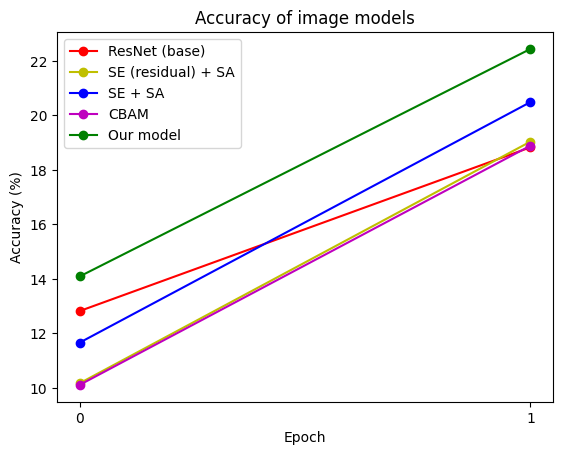

In [9]:
ax = plt.figure()
ax.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for ba, bn, bc in zip(accuracy_list, name_list, color_list):
    plt.plot(ba, label = bn, color = bc, marker='o')
#plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
#plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
plt.title('Accuracy of image models')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# 2. Inference

Compare the ground truth and inference results, and check where the ResNet model paid attention when making inference with GradCam.

In [10]:
import cv2

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image

## 2.1 Set class names

In [11]:
# Label and its index for CIFAR10
# https://www.cs.toronto.edu/~kriz/cifar.html
class_cifar10 = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
                 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Label and its index for CIFAR100
# https://huggingface.co/datasets/cifar100
class_cifar100 = {0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle',
                  8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly',
                  15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee',
                  22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'cra', 27: 'crocodile', 28: 'cup',
                  29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl',
                  36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower',
                  42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle',
                  49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter',
                  56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate',
                  62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road',
                  69: 'rocket', 70: 'rose', 71: 'sea', 72: 'seal', 73: 'shark', 74: 'shrew', 75: 'skunk',
                  76: 'skyscraper', 77: 'snail', 78: 'snake', 79: 'spider', 80: 'squirrel', 81: 'streetcar',
                  82: 'sunflower', 83: 'sweet_pepper', 84: 'table', 85: 'tank', 86: 'telephone', 87: 'television',
                  88: 'tiger', 89: 'tractor', 90: 'train', 91: 'trout', 92: 'tulip', 93: 'turtle', 94: 'wardrobe',
                  95: 'whale', 96: 'willow_tree', 97: 'wolf', 98: 'woman', 99: 'worm'}

## 2.2 Implement functions

In [12]:
def run_inference(args, images, labels):
    print("dataset :", args.dataset)
    print("checkpoint :", args.checkpoint)
    
    if args.dataset == "cifar100":
        num_classes = 100
        classes = class_cifar100
    else:
        num_classes = 10
        classes = class_cifar10

    #############################################
    # Load model
    #############################################
    model = ResNet18(block=args.block, num_classes=num_classes)
    # print(model.layer4)

    cam_layers = [model.layer4]

    device = 'cuda' if torch.cuda.is_available() and not args.cpu else 'cpu'

    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)

    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['net'])

    #############################################
    # Evaluate model
    #############################################    
    np_labels = labels.detach().cpu()    
    output = model(images)
    maxk = 1
    pred = output.topk(maxk, 1, True, True)
    np_indices = pred.indices.detach().cpu()
    print("\nResults")
    print(" - Ground truth : " + str([classes[int(np_labels[j])] for j in range(args.batch_size)]))    
    print(" - Inference    : " + str([classes[int(np_indices[j][0])] for j in range(args.batch_size)]))
    correct_answers = sum(1 if int(np_labels[j]) == int(np_indices[j][0]) else 0 for j in range(args.batch_size))
    print(" - Accuracy     : %3.1f%%" % (correct_answers/args.batch_size*100))

    #############################################
    # Create CAM
    #############################################
    cam = GradCAM(model=model, target_layers=cam_layers, use_cuda=False if device == 'cpu' else True)
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=False if device == 'cpu' else True)

    grayscale_cams = cam(input_tensor=images)

    final_cam = None
    for idx, grayscale_cam in enumerate(grayscale_cams):
        tensor_img = images[idx]

        rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0
        # print(rgb_img)
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        if final_cam is None:
            final_cam = cam_image
        else:
            final_cam = cv2.hconcat([final_cam, cam_image])
        
    fig = plt.figure()
    plt.imshow(final_cam)
    plt.title("GradCam Images")    
    plt.show()

In [13]:
def best_checkpoint(checkpoint_path):
    file_list = os.listdir(checkpoint_path)    
    
    for file_name in sorted(file_list, reverse=True):
        if file_name.startswith('checkpoint_'):
            return checkpoint_path + '/' + file_name
    return ''

## 2.3 Analyze inference results

In [14]:
weight_list = [best_checkpoint('%s/%s/%s' % (args.save_dir, args.dataset, block)) for block in block_list]
weight_list

['weights/resnet18/cifar100/RESNET/checkpoint_96.pth',
 'weights/resnet18/cifar100/SE_SA_1/checkpoint_92.pth',
 'weights/resnet18/cifar100/SEC_SA_1/checkpoint_1.pth',
 'weights/resnet18/cifar100/CBAM_1/checkpoint_1.pth',
 'weights/resnet18/cifar100/NEW_1/checkpoint_1.pth']

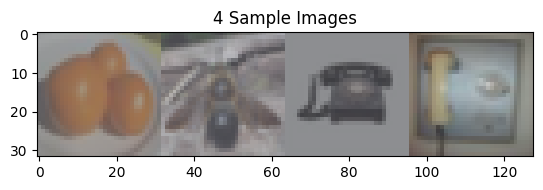


########################################################################################
Inference of "ResNet (base)"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/RESNET/checkpoint_96.pth

Results
 - Ground truth : ['orange', 'bee', 'telephone', 'telephone']
 - Inference    : ['sweet_pepper', 'caterpillar', 'raccoon', 'television']
 - Accuracy     : 0.0%


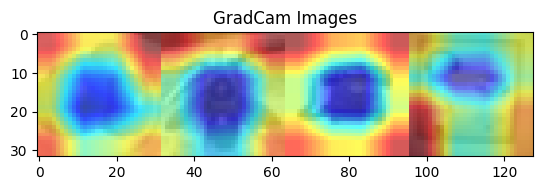

########################################################################################

########################################################################################
Inference of "SE (residual) + SA"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/SE_SA_1/checkpoint_92.pth

Results
 - Ground truth : ['orange', 'bee', 'telephone', 'telephone']
 - Inference    : ['orange', 'spider', 'possum', 'wardrobe']
 - Accuracy     : 25.0%


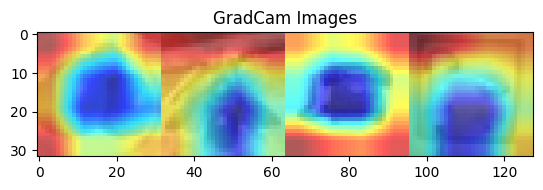

########################################################################################

########################################################################################
Inference of "SE + SA"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/SEC_SA_1/checkpoint_1.pth

Results
 - Ground truth : ['orange', 'bee', 'telephone', 'telephone']
 - Inference    : ['orange', 'snake', 'cockroach', 'forest']
 - Accuracy     : 25.0%


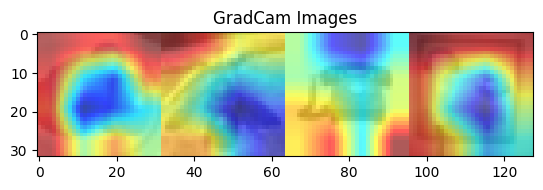

########################################################################################

########################################################################################
Inference of "CBAM"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/CBAM_1/checkpoint_1.pth

Results
 - Ground truth : ['orange', 'bee', 'telephone', 'telephone']
 - Inference    : ['hamster', 'chimpanzee', 'cockroach', 'forest']
 - Accuracy     : 0.0%


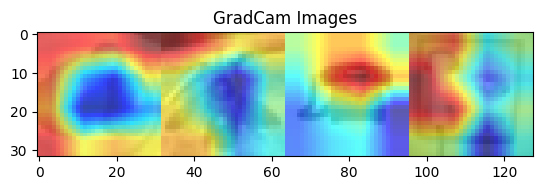

########################################################################################

########################################################################################
Inference of "Our model"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/NEW_1/checkpoint_1.pth

Results
 - Ground truth : ['orange', 'bee', 'telephone', 'telephone']
 - Inference    : ['pear', 'chimpanzee', 'chair', 'rabbit']
 - Accuracy     : 0.0%


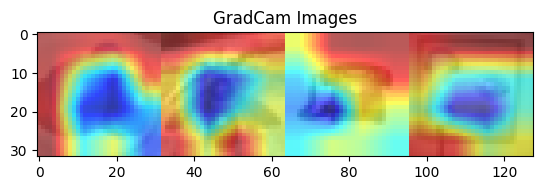

########################################################################################


In [16]:
args.batch_size = 4  # Sample images for inferencing

###########################################################
# Load dataset
###########################################################
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
if args.dataset == "cifar100":
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
else:
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
    
dataiter = iter(val_loader)
images, labels = next(dataiter)

###########################################################
# Display sample images
###########################################################
original_img = None
for tensor_img in images:
    rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0

    if original_img is None:
        original_img = rgb_img
    else:
        original_img = cv2.hconcat([original_img, rgb_img])

fig = plt.figure()
plt.imshow(original_img)
plt.title("%d Sample Images" % args.batch_size)
plt.show()

###########################################################
# Run inference of each model with same sample images
###########################################################
for bt, bn, bw in zip(block_list, name_list, weight_list):
    print()
    print('########################################################################################')
    print('Inference of "%s"' %bn)
    args.block = bt
    args.checkpoint = bw
    run_inference(args, images, labels)
    print('########################################################################################')